# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [59]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "drive/MyDrive/Dataset/images.zip" -d "."
!cp "drive/MyDrive/Dataset/annotations.json" -d "."

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [60]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [61]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)
        self.num_pieces = F.one_hot(self.num_pieces.long()-1, 32)
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = cv2.imread(os.path.join(self.root, self.file_names[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        num_pieces = self.num_pieces[i]

        return image, num_pieces.float()

train_dataset = ChessDataset('', 'train', data_aug)
valid_dataset = ChessDataset('', 'valid', data_in)
test_dataset = ChessDataset('', 'test', data_in)

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


In [62]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

Using cpu device


torch.Size([16, 224, 224, 3])
torch.Size([16, 32])
tensor(21)


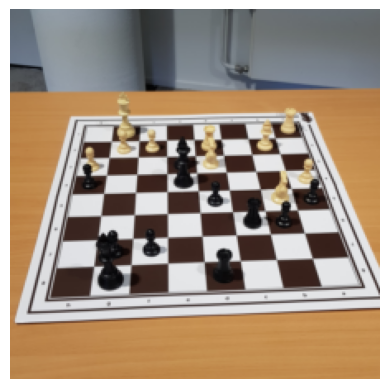

In [63]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels.shape)
    print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

In [78]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
model1 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
num_classes = 32
model1.fc = nn.Linear(model1.fc.in_features, 32)

model1.to(device)

Using cpu device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train the model

Define function to perform one iteration

In [82]:
from tqdm import tqdm
def train_classifier(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, num_epochs=50, lr_scheduler=None):
    
    model = model.to(device)
    
    # Evaluation history
    train_history = {
        'loss': [],
        'acc': [],
    }
    val_history = {
        'loss': [],
        'acc': [],
    }
    for epoch in range(num_epochs):
        # Training 
        model.train()
        epoch_train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            _, predicted = outputs.max(1)
            _, labels_idx = labels.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels_idx).sum().item()
        
        train_loss = epoch_train_loss / len(train_dataloader)
        train_acc = 100. * correct / total
        train_history['loss'].append(train_loss)
        train_history['acc'].append(train_acc)
        
        # Validation 
        val_loss, val_acc = evaluate_classifier(model, val_dataloader, loss_fn, device)
        val_history['loss'].append(val_loss)
        val_history['acc'].append(val_acc)
        
        # # Update learning rate if scheduler provided
        # if lr_scheduler:
        #     if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        #         lr_scheduler.step(val_loss)
        #     else:
        #         lr_scheduler.step()
        
        print(f'Train Loss: {train_loss:.4f} || Train Acc: {train_acc:.2f}')
        print(f'Val Loss: {val_loss:.4f} || Val Acc: {val_acc:.2f}')
    
    return train_history, val_history

def evaluate_classifier(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.argmax(dim=1))
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            _, labels_idx = labels.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels_idx).sum().item()
    
    loss = running_loss / len(dataloader)
    acc = 100. * correct / total
    return loss, acc

Define loss, optimizer and train the model

In [80]:
import torch.optim as optim

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer_phase1 = optim.Adam(model1.fc.parameters(), lr=0.001)
optimizer_phase2 = optim.Adam(model1.fc.parameters(), lr=0.0001)

## Analyse training evolution

In [81]:
# 1 Phase: train with frozen layers
for name, param in model1.named_parameters():
    if not name.startswith('fc'):
        param.requires_grad = False

train_history_phase1, val_history_phase1 = train_classifier(
    model1, train_dataloader, valid_dataloader, loss_fn, optimizer_phase1, device, num_epochs=10
)

Epoch 1/10 [Training]: 100%|████████████████████| 90/90 [06:34<00:00,  4.38s/it]


Train Loss: 3.4550 || Train Acc: 7.01
Val Loss: 3.5753 || Val Acc: 5.15


Epoch 2/10 [Training]:  52%|██████████▍         | 47/90 [03:45<03:26,  4.81s/it]


KeyboardInterrupt: 

In [ ]:
# 2nd Phase: train whole model (unfreeze)
for param in model1.parameters():
    param.requires_grad = True
    
train_history_phase2, val_history_phase2 = train_classifier(
    model1, train_dataloader, valid_dataloader, loss_fn, optimizer_phase2, device, num_epochs=40
)

Plot loss and accuracy throughout training on train and validation data

In [ ]:
train_history = train_history_phase1.extend(train_history_phase2)
val_history = val_history_phase1.extend(val_history_phase2)

In [ ]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

In [ ]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [2]:
# Load the best model

# Evaluate model on test data
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def test_classifier(model, test_dataloader, device):
    model.eval()
    model.to(device)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            _, labels_idx = labels.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels_idx.cpu().numpy())
    
    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (weighted): {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'true_labels': all_labels
    }
test_results = test_classifier(model1, test_dataloader, device)

In [ ]:
test_results = test_classifier(model1, test_dataloader, device)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?

In [ ]:
# Regression mdoel
model2 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Change the last layer for regression (single output neuron)
model2.fc = nn.Linear(model2.fc.in_features, 1)

model2.to(device)

In [ ]:
def train_regressor(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, num_epochs=50, lr_scheduler=None):
    
    model = model.to(device)
    
    # Evaluation history
    train_history = {
        'loss': [],
        'mae': [],
    }
    val_history = {
        'loss': [],
        'mae': [],
    }
    
    for epoch in range(num_epochs):
        # Training 
        model.train()
        epoch_train_loss = 0.0
        epoch_train_mae = 0.0
        
        for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            epoch_train_mae += torch.nn.functional.l1_loss(outputs.squeeze(), labels).item()
        
        train_loss = epoch_train_loss / len(train_dataloader)
        train_mae = epoch_train_mae / len(train_dataloader)
        train_history['loss'].append(train_loss)
        train_history['mae'].append(train_mae)
        
        # Validation 
        val_loss, val_mae = evaluate_regressor(model, val_dataloader, loss_fn, device)
        val_history['loss'].append(val_loss)
        val_history['mae'].append(val_mae)
        
        print(f'Train Loss: {train_loss:.4f} || Train MAE: {train_mae:.4f}')
        print(f'Val Loss: {val_loss:.4f} || Val MAE: {val_mae:.4f}')
    
    return train_history, val_history

def evaluate_regressor(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    running_mae = 0.0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()  # Ensure labels are float for regression
            
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            
            running_loss += loss.item()
            running_mae += torch.nn.functional.l1_loss(outputs.squeeze(), labels).item()
    
    loss = running_loss / len(dataloader)
    mae = running_mae / len(dataloader)
    return loss, mae

In [ ]:
# Loss Function
loss_fn_r = nn.MSELoss()

# Optimizer
optimizer_phase1 = optim.Adam(model1.fc.parameters(), lr=0.001)
optimizer_phase2 = optim.Adam(model1.parameters(), lr=0.0001)

In [ ]:
# Phase 1: train with frozen params
for name, param in model2.named_parameters():
    if not name.startswith('fc'):
        param.requires_grad = False

train_history_r_phase1, val_history_r_phase1 = train_regressor(
    model2, train_dataloader, valid_dataloader, loss_fn_r, optimizer_phase1, device, num_epochs=10
)

In [ ]:
# 2nd Phase: train whole model (unfreeze)
for param in model2.parameters():
    param.requires_grad = True
    
train_history_r_phase2, val_history_r_phase2 = train_regressor(
    model2, train_dataloader, valid_dataloader, loss_fn_r, optimizer_phase2, device, num_epochs=40
)

In [ ]:
train_history_r = train_history_r_phase1.extend(train_history_r_phase2)
val_history_r = val_history_r_phase1.extend(val_history_r_phase2)

In [ ]:
# Plot training and validation process
plotTrainingHistory(train_history_r, val_history_r)

In [ ]:
# Test Evaluation
def test_regressor(model, test_dataloader, device):
    model.eval()
    predictions = []
    true_values = []
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            
            outputs = model(inputs)
            
            predictions.extend(outputs.cpu().numpy().flatten())
            true_values.extend(labels.cpu().numpy().flatten())
    
    return np.array(predictions), np.array(true_values)

predictions, true_values = evaluate_on_test_set(model1, test_dataloader, device)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(true_values, predictions)
mse = mean_squared_error(true_values, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(true_values, predictions)

print(f"\nTest Metrics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(true_values, predictions, alpha=0.5)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

# Errors Histogram
errors = predictions - true_values
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution')
plt.show()